In [67]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
import pmdarima as pm
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

Data Loading and Formatting

In [68]:
global STATE
STATE = "Utah"

global PERIOD
PERIOD = 12

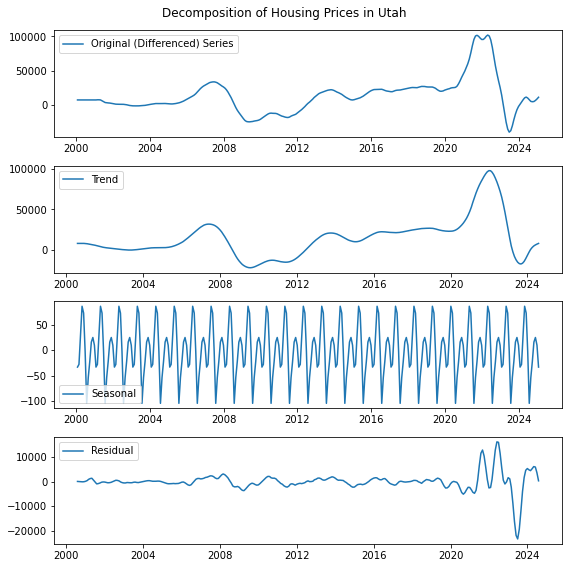

In [69]:
df = pd.read_csv("Data_Files/price_by_state_cleaned.csv")

# convert the month column to datetime format and set it as the index of the dataframe
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index(['Unnamed: 0'], inplace=True)

# difference the data
df = df.diff(periods=PERIOD)
df.fillna(method='backfill', inplace=True)

# identify seasonal component
result = seasonal_decompose(df[STATE], model='additive', period=PERIOD)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# plot the decomposed components
plt.figure(figsize=(8,8))
plt.subplot(4, 1, 1)
plt.plot(df[STATE], label="Original (Differenced) Series")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label="Trend")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label="Seasonal")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label="Residual")
plt.legend()

plt.suptitle(f"Decomposition of Housing Prices in {STATE}")
plt.tight_layout()
plt.show()

SARIMAX Model Fitting

In [70]:
# create an exogenous variable
df['month_index'] = df.index.month

# initialize model
SARIMAX_model = pm.auto_arima(df[[STATE]], exogenous=df[['month_index']],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=4, max_q=4,
                              m=PERIOD,
                              start_P=0, seasonal=True,
                              d=None, D=1, 
                              trace=False,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

SARIMAX Forecasting Function

In [73]:
def sarimax_forecast(SARIMAX_model, periods=24):
    n_periods = periods

    forecast_df = df 
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True,
                                            exogenous=forecast_df[["month_index"]])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    print(fitted_series)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(df[STATE])
    plt.plot(fitted_series, color='r')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)
    
    plt.show()


2025-03-01   NaN
2025-04-01   NaN
2025-05-01   NaN
2025-06-01   NaN
2025-07-01   NaN
2025-08-01   NaN
2025-09-01   NaN
2025-10-01   NaN
2025-11-01   NaN
2025-12-01   NaN
2026-01-01   NaN
2026-02-01   NaN
2026-03-01   NaN
2026-04-01   NaN
2026-05-01   NaN
2026-06-01   NaN
2026-07-01   NaN
2026-08-01   NaN
2026-09-01   NaN
2026-10-01   NaN
2026-11-01   NaN
2026-12-01   NaN
2027-01-01   NaN
2027-02-01   NaN
Freq: MS, dtype: float64


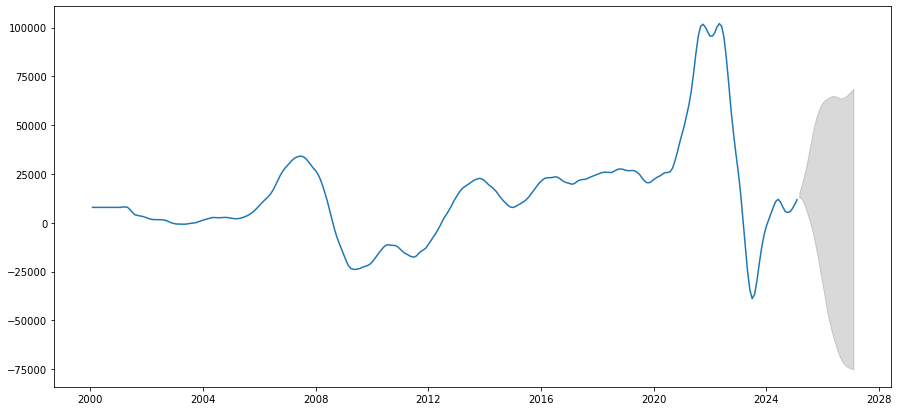

In [74]:
sarimax_forecast(SARIMAX_model)